In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from IPython.display import clear_output
import numpy as np
import os
import pandas as pd
import shutil

import sys
sys.path.append('..')

from lib.XGB import XGB
from lib.ChurnEnsemble import ChurnEnsemble
from lib.utils import format_number, show_summary

SEED = 42
np.random.seed(SEED)

2024-07-02 19:58:51.794711: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
config = dict(
    features=[
        'employees', 'interval', 'country_es', 'country_mx', 'country_latam', 'gateway_auto',
        'plan', 'usage', 'usage_groups', 'usage_payments', 'usage_avg',
        'paid_periods', 'months', 'failed_ratio', 'momentum'
    ],
    params={}
)

min_tte = 1  # Minimum time to event for binary classification (positive if `tte` <= `min_tte`)
test_size = 0.25  # Percentage of the data to use for test/validation

In [3]:
def print_censored_rate(
    data: pd.DataFrame,
    name: str = 'Total'
):
    """
    Print the censored rate for the given data.
    Censored sequences are the ones where the churn date is not known (last `tte` < 0).

    Parameters
    ----------
    data : pd.DataFrame, optional
        Data to calculate the censored rate.
        If not provided, model data will be used.
    name : str, optional
        Name to print the censored rate.
    """
    cs = pd.Categorical(
        data.sort_values(['id', 'tp']).groupby('id')['tte'].last() < 0,
        categories=[False, True]
    ).value_counts().astype(float)

    print('{} Customers: {} | Censored: {} | Non-censored: {} | Censored Rate {}%'.format(
        name,
        format_number(cs.sum()),
        format_number(cs[True]),
        format_number(cs[False]),
        format_number(100 * cs[True] / cs.sum(), 2)
    ))

In [4]:
data = pd.read_csv('../files/churn-seq-fit.csv')

clear_output(wait=True)
print_censored_rate(data)
data

Total Customers: 11.637 | Censored: 2.381 | Non-censored: 9.256 | Censored Rate 20,46%


,cid,id,tp,tfs,tte,ts,te,employees,mrr,value,...,usage_avg,usage_groups_avg,usage_payments_avg,paid_periods,failed_periods,active_periods,months,failed_ratio,usage_diff,momentum
0,5142ef7b2169540c17000001,1,2015-03-01,0.0,1.0,2015-03-01,2015-04-01,3,10.90,10.90,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5142ef7b2169540c17000001,1,2015-04-01,1.0,0.0,2015-03-01,2015-04-01,3,10.90,10.90,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,-2.2
2,51643b584bcdb1cc6800001e,2,2015-01-01,0.0,26.0,2015-01-01,2017-03-01,1,9.26,9.26,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,51643b584bcdb1cc6800001e,2,2015-02-01,1.0,25.0,2015-01-01,2017-03-01,1,9.26,18.52,...,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0
4,51643b584bcdb1cc6800001e,2,2015-03-01,2.0,24.0,2015-01-01,2017-03-01,1,8.26,117.69,...,0.0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215641,66103d1c508579d0d5fc9727,11633,2024-03-01,0.0,1.0,2024-03-01,2024-04-01,1,52.79,52.79,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
215642,66105263508579d0d5fca27d,11634,2024-03-01,0.0,-1.0,2024-03-01,NaN,1,72.75,72.75,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
215643,661063c1508579d0d5fcae2c,11635,2024-03-01,0.0,-1.0,2024-03-01,NaN,1,41.97,41.97,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
215644,66106e13423bb304f227d752,11636,2024-03-01,0.0,-1.0,2024-03-01,NaN,1,32.15,32.15,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# Clean previous data path
if os.path.exists('../files/xgb'):
    shutil.rmtree('../files/xgb')

# Instantiate Ensemble model, set parameters and data
model = ChurnEnsemble(
    min_tte=min_tte,
    seed=SEED,
    verbose=1,
    path='../files/xgb'
).set_data(
    data,
    test_size=test_size
)

print_censored_rate(model.dtrain, 'Train')
print_censored_rate(model.dtest, 'Test')

Train Customers: 8.727 | Censored: 1.786 | Non-censored: 6.941 | Censored Rate 20,47%
Test Customers: 2.910 | Censored: 595 | Non-censored: 2.315 | Censored Rate 20,45%


In [6]:
# Instantiate the XGBoost model
xgb = XGB(
    features=config['features'],
    min_tte=min_tte,
    seed=SEED,
    verbose=1,
    path='../files/xgb',
    **config['params']
)

xgb.params

{'n': 200,
 'lr': 0.01,
 'max_depth': 16,
 'stop': 0,
 'metric': 'auc',
 'min_child_weight': 1,
 'gamma': 0,
 'weight_l1': 0,
 'weight_l2': 1,
 'dropout': 0.2,
 'shuffle': False,
 'reg_unb': True}

In [7]:
# Select train data
d_xgb_train = data[data['id'].isin(model.dtrain['id'])].sort_values(['id', 'tfs'])[
    ['id', 'tfs', 'tte'] + xgb.features
]

# Build train tensor
x_xgb_train, y_xgb_train = xgb.build_seq(d_xgb_train)
df_xgb_train = xgb.seq_to_df(x_xgb_train, y_xgb_train)

show_summary(df_xgb_train, xgb.tgt_col)
df_xgb_train

Shape: 161,947 x 18
    0.0: 148,357 (91.61%)
    1.0: 13,590 (8.39%)


,id,tfs,tgt,employees,interval,country_es,country_mx,country_latam,gateway_auto,plan,usage,usage_groups,usage_payments,usage_avg,paid_periods,months,failed_ratio,momentum
0,1.0,0.0,1.0,3.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.00
1,1.0,1.0,1.0,3.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,-2.20
2,3.0,0.0,0.0,1.0,3.0,1.0,0.0,0.0,1.0,2.0,2.0,0.0,0.0,2.0,1.0,0.0,0.0,0.00
3,3.0,1.0,0.0,1.0,3.0,1.0,0.0,0.0,1.0,2.0,2.0,0.0,0.0,2.0,1.0,1.0,0.0,-0.05
4,3.0,2.0,0.0,1.0,3.0,1.0,0.0,0.0,1.0,2.0,2.0,0.0,0.0,2.0,1.0,2.0,0.0,0.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161942,11631.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.00
161943,11632.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.00
161944,11633.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.00
161945,11636.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.00


In [8]:
# Select test data
d_xgb_test = data[data['id'].isin(model.dtest['id'])].sort_values(['id', 'tfs'])[
    ['id', 'tfs', 'tte'] + xgb.features
]

# Build test tensor
x_xgb_test, y_xgb_test = xgb.build_seq(d_xgb_test)
df_xgb_test = xgb.seq_to_df(x_xgb_test, y_xgb_test)

show_summary(df_xgb_train, xgb.tgt_col)
df_xgb_test

Shape: 161,947 x 18
    0.0: 148,357 (91.61%)
    1.0: 13,590 (8.39%)


,id,tfs,tgt,employees,interval,country_es,country_mx,country_latam,gateway_auto,plan,usage,usage_groups,usage_payments,usage_avg,paid_periods,months,failed_ratio,momentum
0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0
2,2.0,2.0,0.0,1.0,12.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0
3,2.0,3.0,0.0,1.0,12.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0
4,2.0,4.0,0.0,1.0,12.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,4.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53694,11624.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
53695,11627.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
53696,11630.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
53697,11634.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [9]:
# Fit XGBoost model
xgb.fit(x_xgb_train, y_xgb_train, x_xgb_test, y_xgb_test)

[0]	validation_0-auc:0.92434	validation_1-auc:0.82003
[1]	validation_0-auc:0.94389	validation_1-auc:0.83715
[2]	validation_0-auc:0.94987	validation_1-auc:0.84419
[3]	validation_0-auc:0.95399	validation_1-auc:0.85104
[4]	validation_0-auc:0.95501	validation_1-auc:0.85573
[5]	validation_0-auc:0.95602	validation_1-auc:0.85763
[6]	validation_0-auc:0.95796	validation_1-auc:0.86181
[7]	validation_0-auc:0.95874	validation_1-auc:0.86436
[8]	validation_0-auc:0.95935	validation_1-auc:0.86525
[9]	validation_0-auc:0.95908	validation_1-auc:0.86568
[10]	validation_0-auc:0.95968	validation_1-auc:0.86674
[11]	validation_0-auc:0.96044	validation_1-auc:0.86699
[12]	validation_0-auc:0.96082	validation_1-auc:0.86777
[13]	validation_0-auc:0.96136	validation_1-auc:0.86807
[14]	validation_0-auc:0.96170	validation_1-auc:0.86873
[15]	validation_0-auc:0.96190	validation_1-auc:0.86933
[16]	validation_0-auc:0.96218	validation_1-auc:0.86978
[17]	validation_0-auc:0.96251	validation_1-auc:0.87033
[18]	validation_0-au

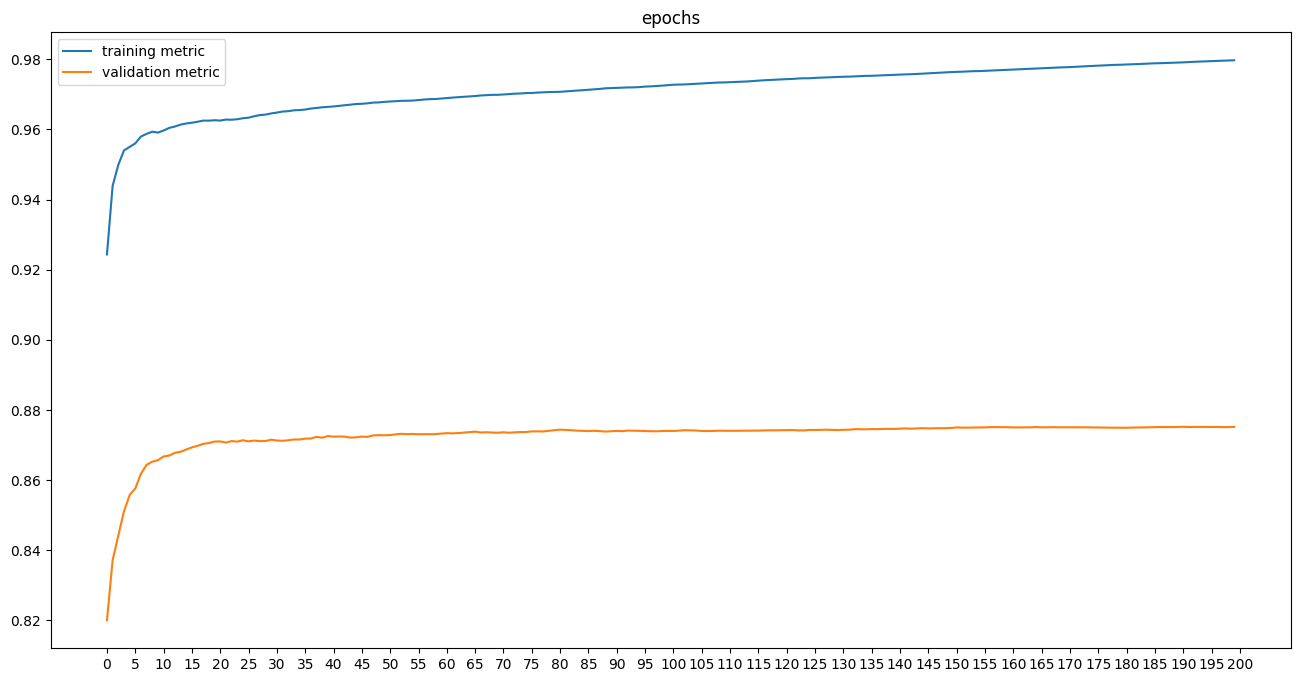

In [10]:
# Save model
xgb.save()

# Plot training history
xgb.plot_history_eval()

In [11]:
# Predict
y_xgb_hat = xgb.predict(x_xgb_test)
# Set results
xgb.set_results(y_xgb_hat, y_xgb_test)

# Prediction results
xgb.results

,id,tfs,pred,true
0,2,0,0.511939,0.0
1,2,1,0.531058,0.0
2,2,2,0.125403,0.0
3,2,3,0.143440,0.0
4,2,4,0.138635,0.0
...,...,...,...,...
53694,11624,0,0.715110,0.0
53695,11627,0,0.715110,0.0
53696,11630,0,0.649435,0.0
53697,11634,0,0.608215,0.0


In [12]:
# Get the last sequence prediction for each customer
results = (
    xgb.results
    .sort_values(['id', 'tfs'])
    .groupby('id')
    .last()
    .drop(columns=['tfs'])
    .reset_index()
)

show_summary(results, 'true')
results

Shape: 2,910 x 3
    1.0: 2,284 (78.49%)
    0.0: 626 (21.51%)


,id,pred,true
0,2,0.227129,1.0
1,4,0.507943,1.0
2,7,0.096384,0.0
3,8,0.815374,1.0
4,10,0.659274,1.0
...,...,...,...
2905,11624,0.715110,0.0
2906,11627,0.715110,0.0
2907,11630,0.649435,0.0
2908,11634,0.608215,0.0


In [13]:
# Set the XGBoost model
model.xgb = xgb

model

In [14]:
# Set model results from XGB predictions
model.set_results(xgb.results)
# Compute and set model scores
model.set_scores(xgb.results)

model.results

,id,tfs,pred,true,tgt,segment,wa,wb,momentum,cid
0,2,0,0.511939,0.0,1,4,NaN,NaN,0.0,51643b584bcdb1cc6800001e
1,2,1,0.531058,0.0,1,4,NaN,NaN,0.0,51643b584bcdb1cc6800001e
2,2,2,0.125403,0.0,0,1,NaN,NaN,0.0,51643b584bcdb1cc6800001e
3,2,3,0.143440,0.0,0,1,NaN,NaN,0.0,51643b584bcdb1cc6800001e
4,2,4,0.138635,0.0,0,1,NaN,NaN,0.0,51643b584bcdb1cc6800001e
...,...,...,...,...,...,...,...,...,...,...
53694,11624,0,0.715110,0.0,1,5,NaN,NaN,0.0,660ecafcb6080c67b1acee3f
53695,11627,0,0.715110,0.0,1,5,NaN,NaN,0.0,660eff0c508579d0d5f9a75b
53696,11630,0,0.649435,0.0,1,4,NaN,NaN,0.0,660f307c508579d0d5f9bd32
53697,11634,0,0.608215,0.0,1,4,NaN,NaN,0.0,66105263508579d0d5fca27d


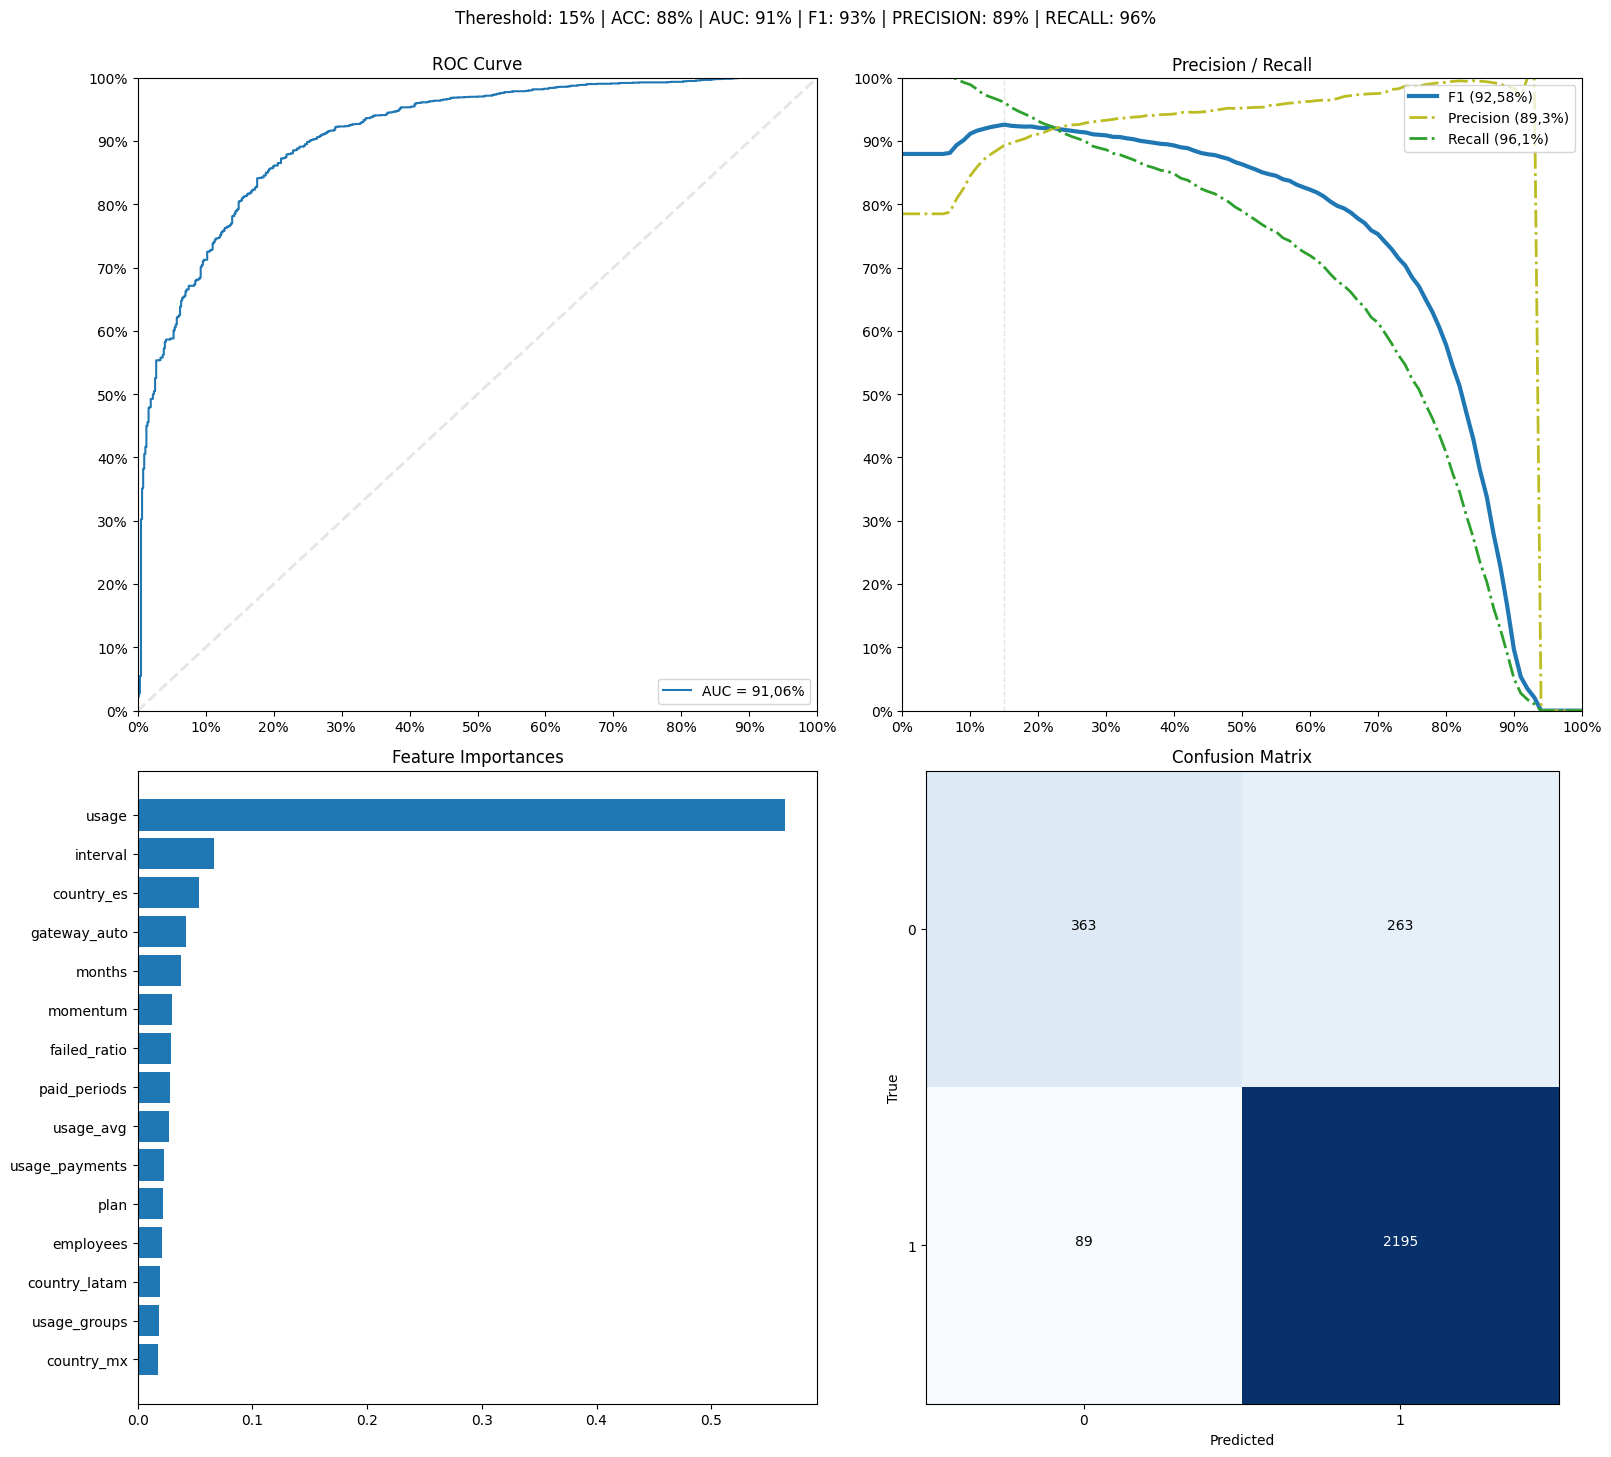

In [15]:
# Plot scores summary
model.plot_scores(xgb.results)

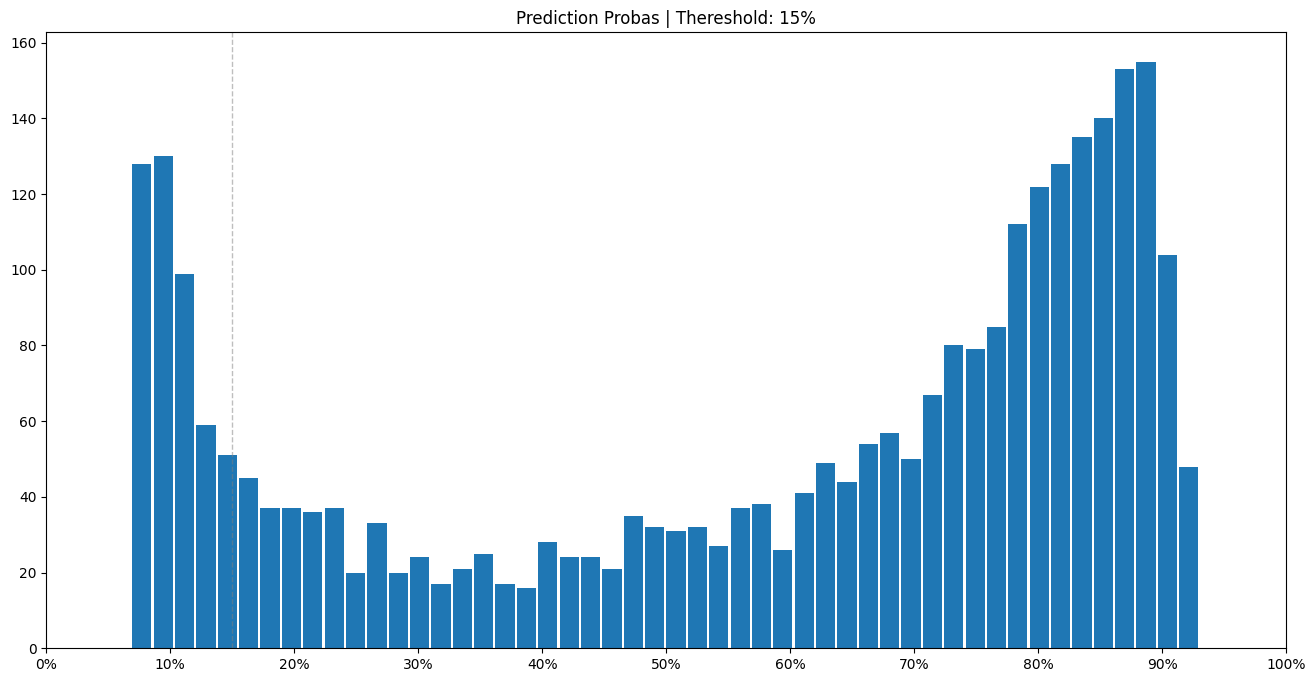

In [16]:
# Plot the histogram of the predicted probabilities for each customer sequence.
model.plot_histogram(xgb.results, loc=-1)